# Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

## Data description
- `city`: city this user signed up in
- `phone`: primary device for this user
- `signup_date`: date of account registration; in the form ‘YYYYMMDD’
- `last_trip_date`: the last time this user completed a trip; in the form ‘YYYYMMDD’
- `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips
- `surge_pct`: the percent of trips taken with surge multiplier > 1
- `avg_surge`: The average surge multiplier over all of this user’s trips
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up
- `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- `weekday_pct`: the percent of the user’s trips occurring during a weekday

# _Set Up_

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
path = os.getcwd()
path + '/data/ultimate_data_challenge.json'

'/Users/joeai/Springboard/unit17-take-home-challenges/ultimate_technologies/data/ultimate_data_challenge.json'

# _Load Data_

In [31]:
from ultimate_challenge import predict

df = predict.load_data(path)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [33]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
dtype: int64

# _Observations_ 

Looks like we have some missing values in the `avg_rating_by_driver`, `avg_rating_of_driver` and `phone` columns. Additionally there are two columns - `last_trip_date` and `signup_date` - that are currently set to object data types when they would be more useful in a datetime format. 

So let's change those columns to datetime then dive a little further into the columns with missing values to figure out the best approach.

In [34]:
# change last_trip_date and signup_date 
df[['last_trip_date', 'signup_date']] = df[['last_trip_date', 'signup_date']].apply(pd.to_datetime)
df[['last_trip_date', 'signup_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
last_trip_date    50000 non-null datetime64[ns]
signup_date       50000 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 781.3 KB


The mean for the avg_rating_by_driver column is equal to 4.778158195947439
------------------------------
The mean for the avg_rating_of_driver column is equal to 4.6015592912744685
------------------------------


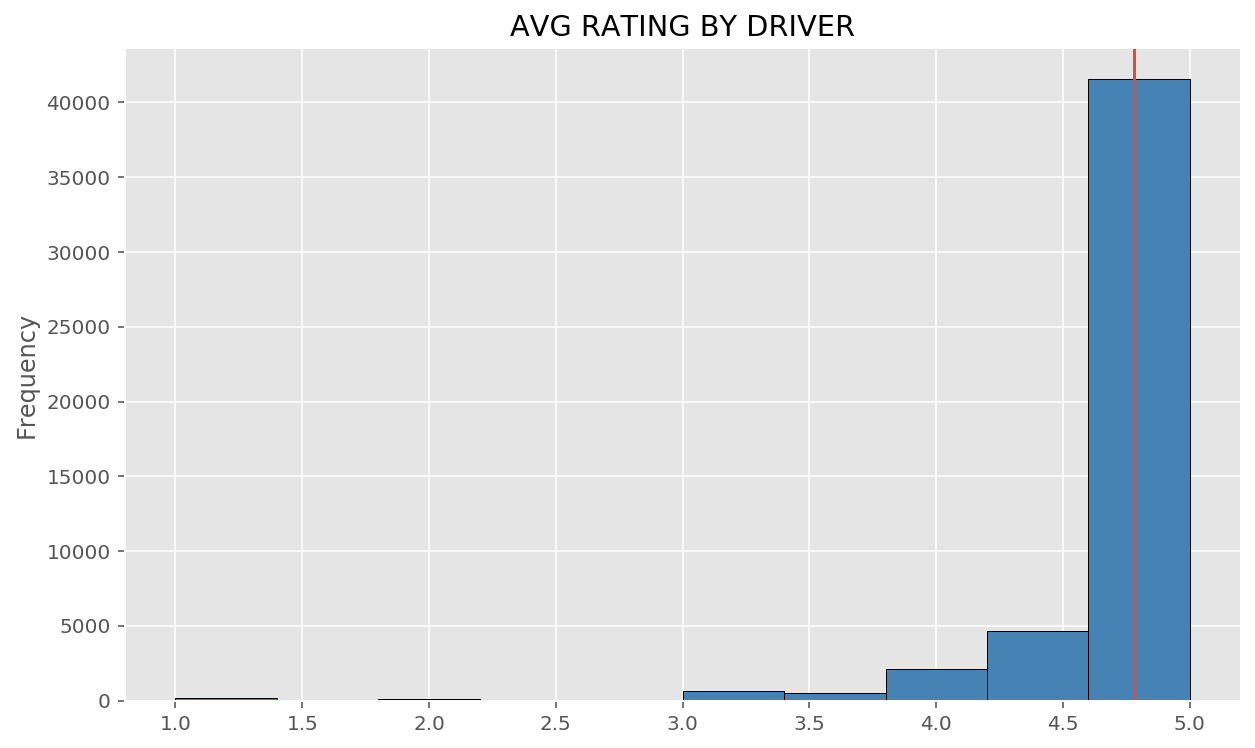

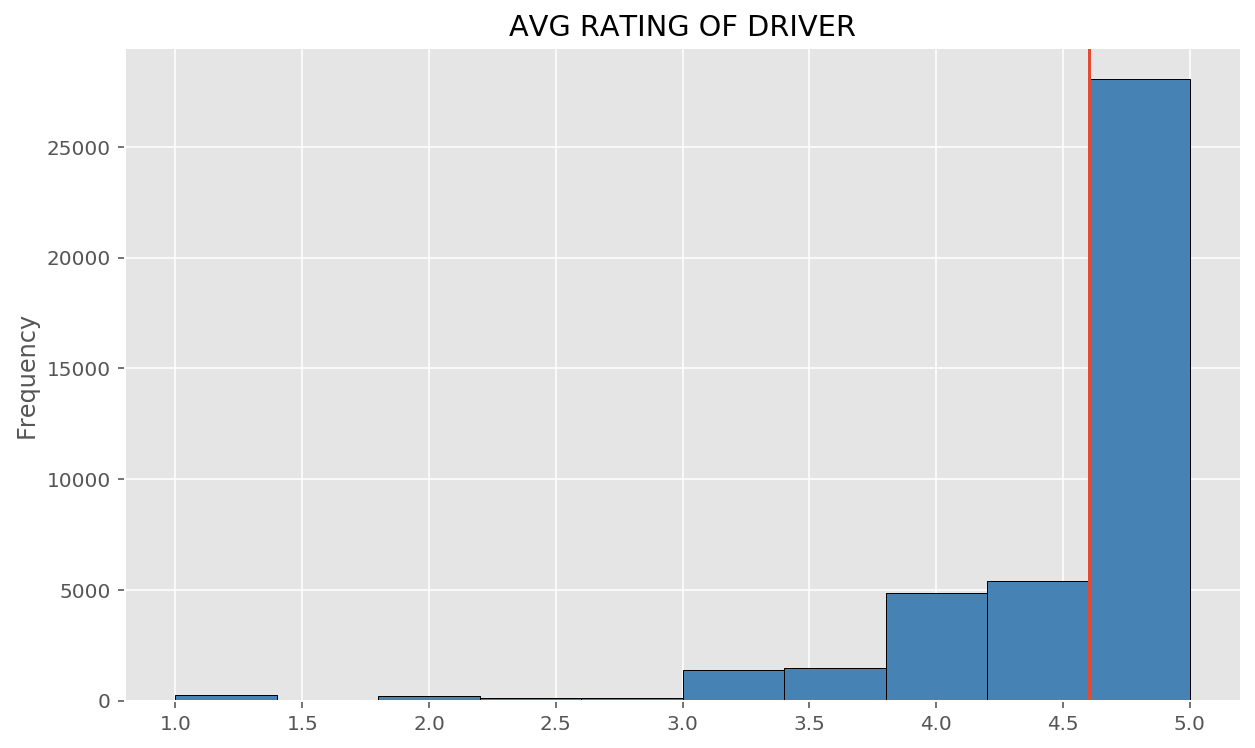

In [35]:
# generate histogram 
predict.multi_hist_plot(df, ['avg_rating_by_driver', 'avg_rating_of_driver'])

# _Observations_

The ratings by the driver and of the driver are both highly skewed. In order to preserve this distribution (as it is pretty significant) how should we address the missing values in `avg_rating_by_driver` & `avg_rating_of_driver`? A simple yet effective strategy is replacing these missing values with the mean, which is was we'll do next.

In [36]:
df['avg_rating_by_driver'].fillna(np.mean(df['avg_rating_by_driver']), inplace=True)
df['avg_rating_of_driver'].fillna(np.mean(df['avg_rating_of_driver']), inplace=True)

In [37]:
df[['avg_rating_by_driver', 'avg_rating_of_driver']].isnull().sum()

avg_rating_by_driver    0
avg_rating_of_driver    0
dtype: int64

In [38]:
# double check to see if there are any other columns with missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


# _Observations_

It looks like we have one last column that has missing values - `phone`. Before we can start to analyze it though, we have to convert it from a object data type to a categorical one. 

In [39]:
df['phone'] = df['phone'].astype('category')
df['phone'].dtype

CategoricalDtype(categories=['Android', 'iPhone'], ordered=False)

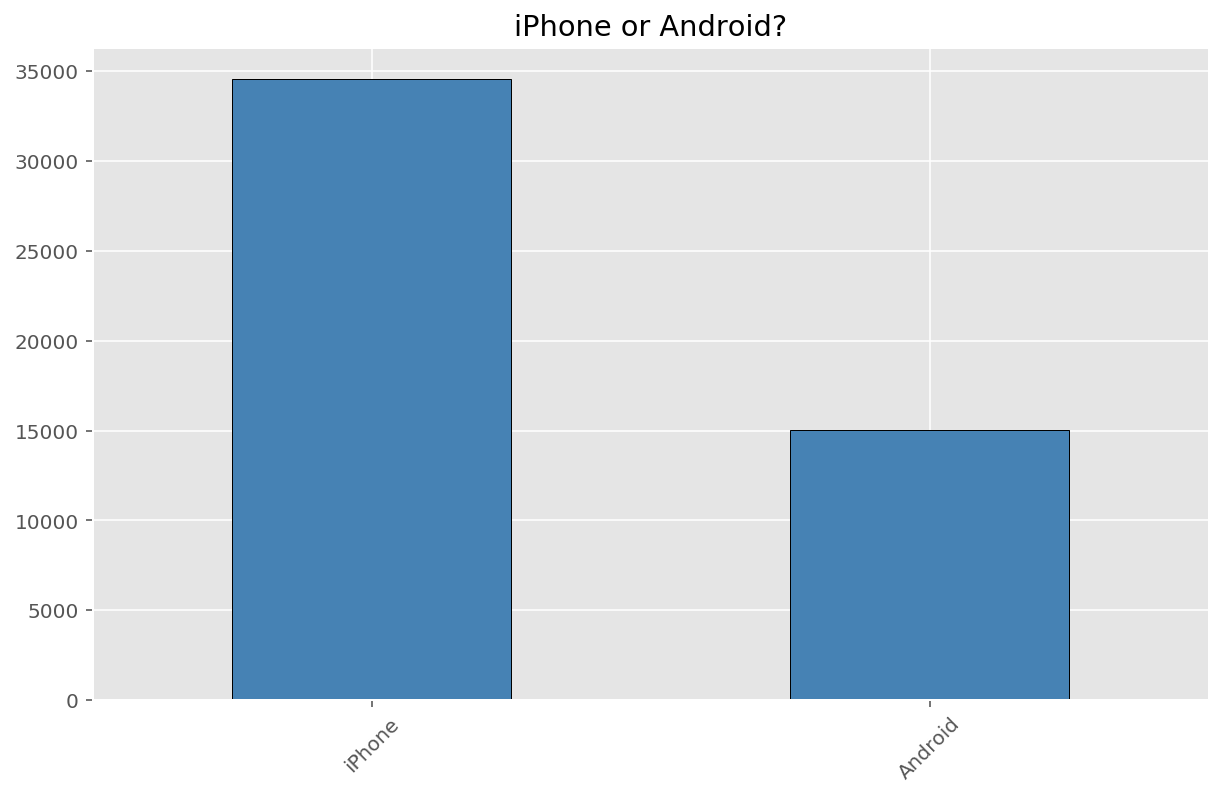

In [40]:
predict.value_counts_plot(df, 'phone', 'iPhone or Android?')

In [43]:
df['phone'].value_counts(normalize=True, dropna=False)

iPhone     0.69164
Android    0.30044
NaN        0.00792
Name: phone, dtype: float64

# _Observations_

As we can see above, it looks to be a 70/30 split approximately in favor of the iPhone. Because this column is a categorical data type, we can't use the mean like we did before. 

What we'll do instead is randomly choose either `iPhone` or `Android` according to their probabilities (i.e. 0.69 or 0.31) and assign that value into missing observations. 

In [44]:
df['phone'] = df['phone'].fillna(np.random.choice(['iPhone', 'Android'], p = [0.69, 0.31]))

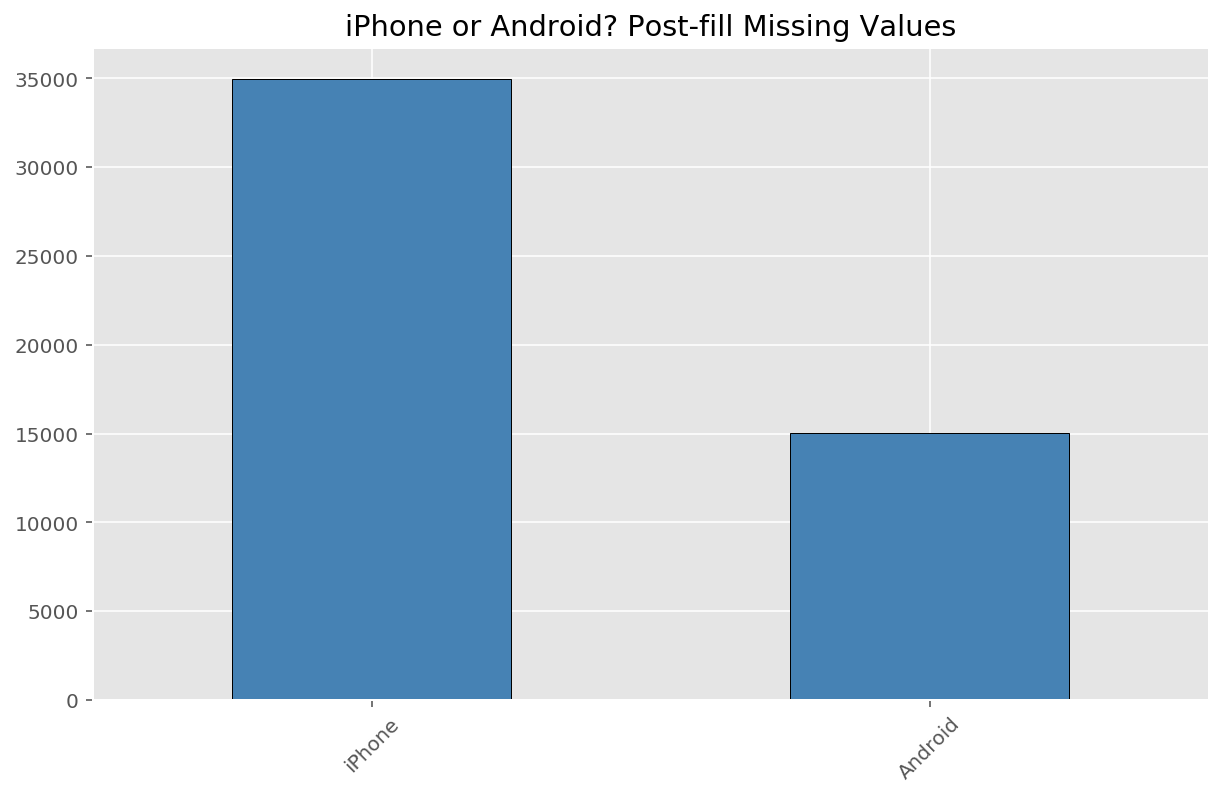

In [45]:
predict.value_counts_plot(df, 'phone', 'iPhone or Android? Post-fill Missing Values')

In [46]:
df['phone'].value_counts(normalize=True, dropna=False)

iPhone     0.69956
Android    0.30044
Name: phone, dtype: float64

In [48]:
# change city to category type
df['city'] = df['city'].astype('category')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), category(2), datetime64[ns](2), float64(6), int64(1)
memory usage: 3.6 MB


# _Observations_

No more missing values! Looks like we can dive a little bit deeper and do some EDA on the columns to get a better picture of their respective distributions.

In [51]:
number_cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
              'weekday_pct']

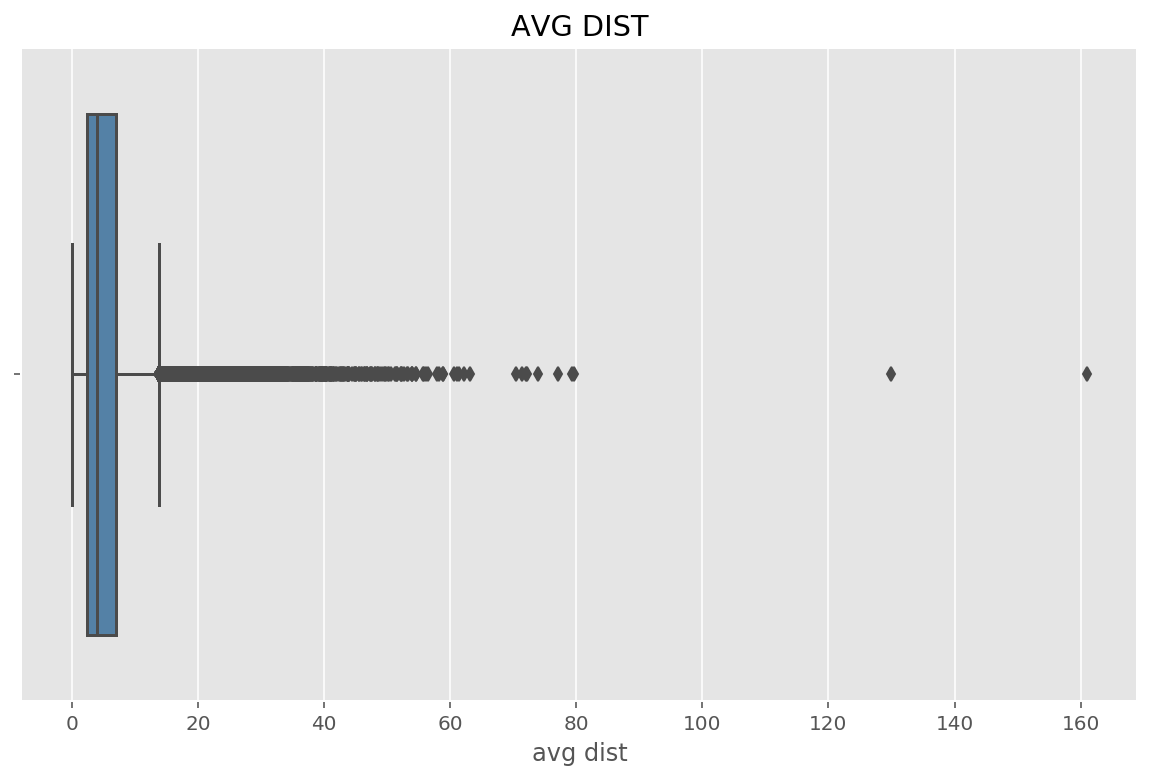

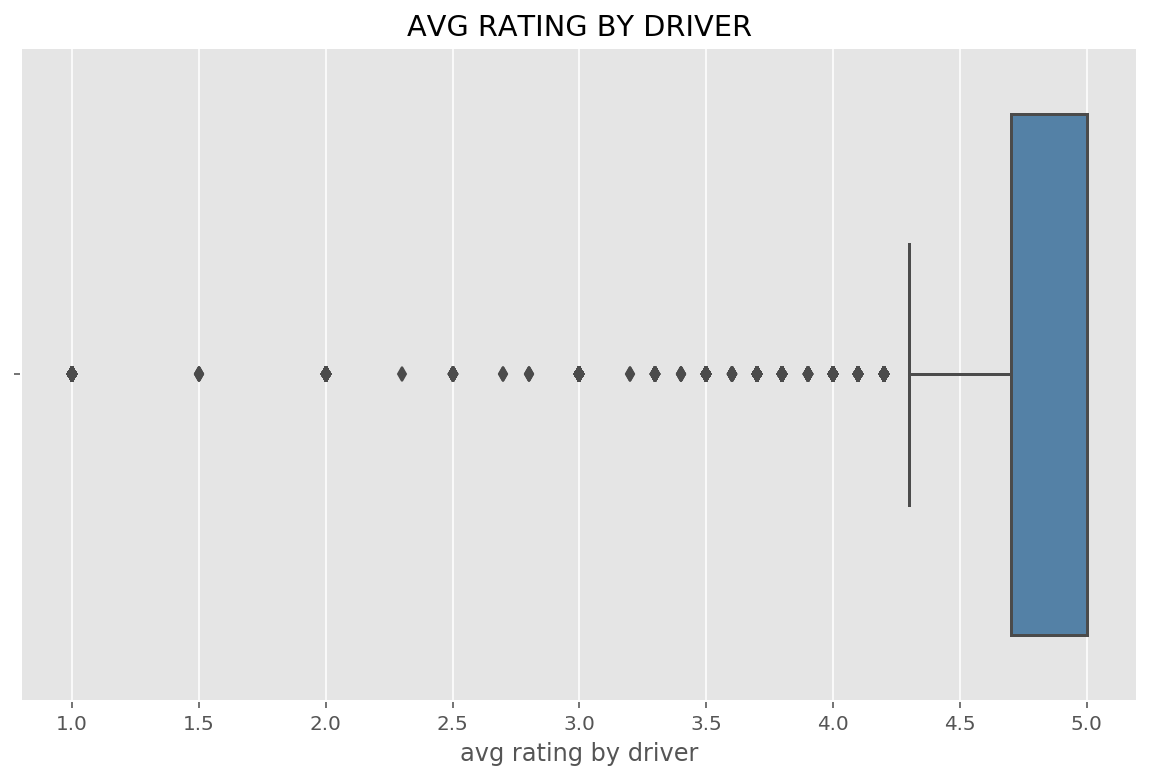

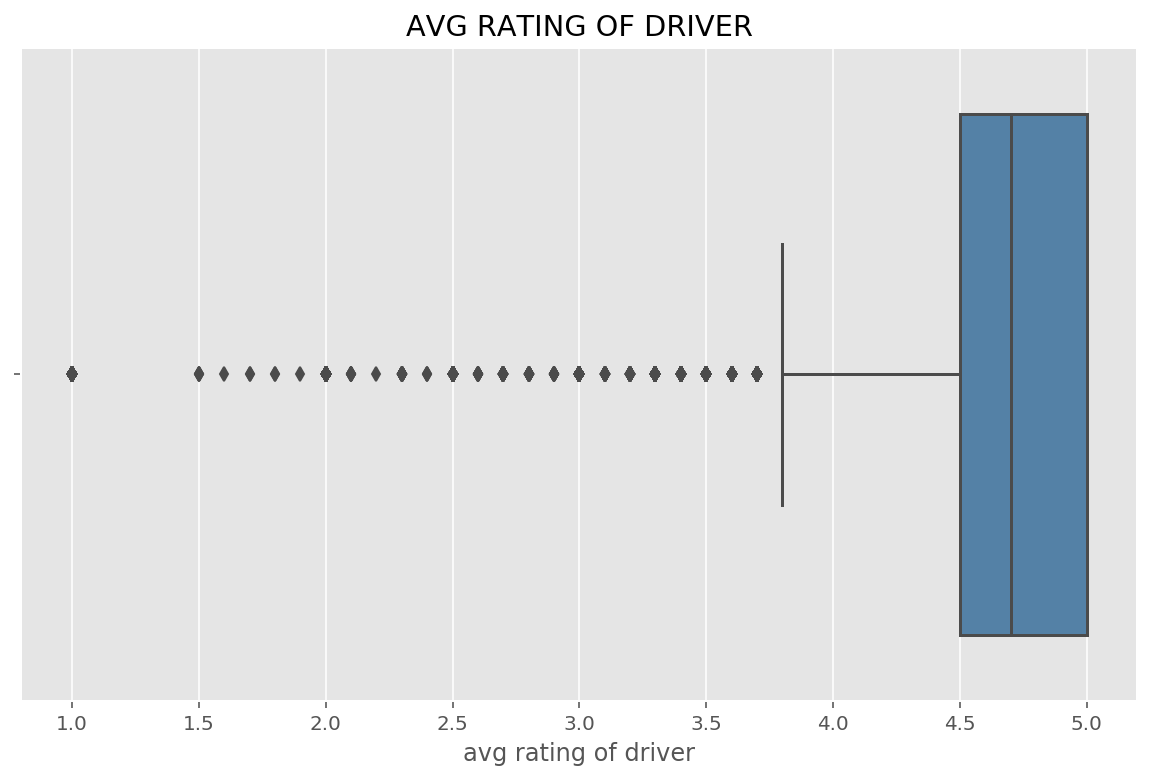

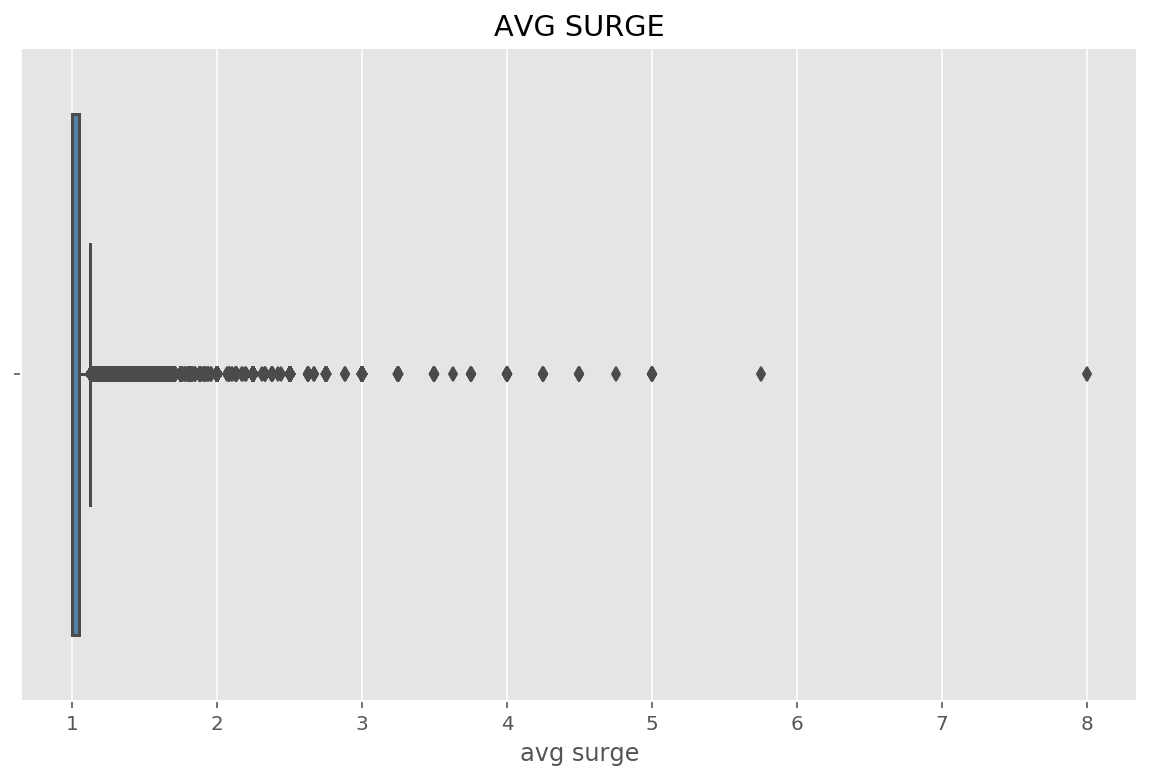

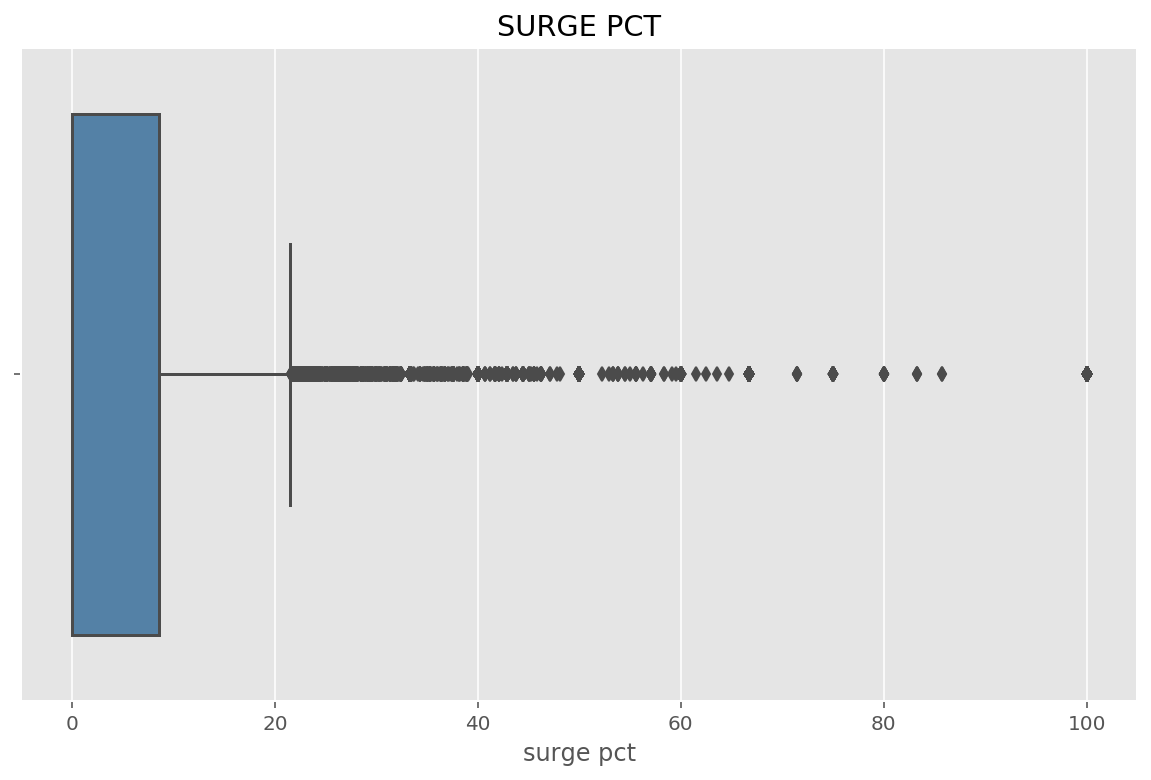

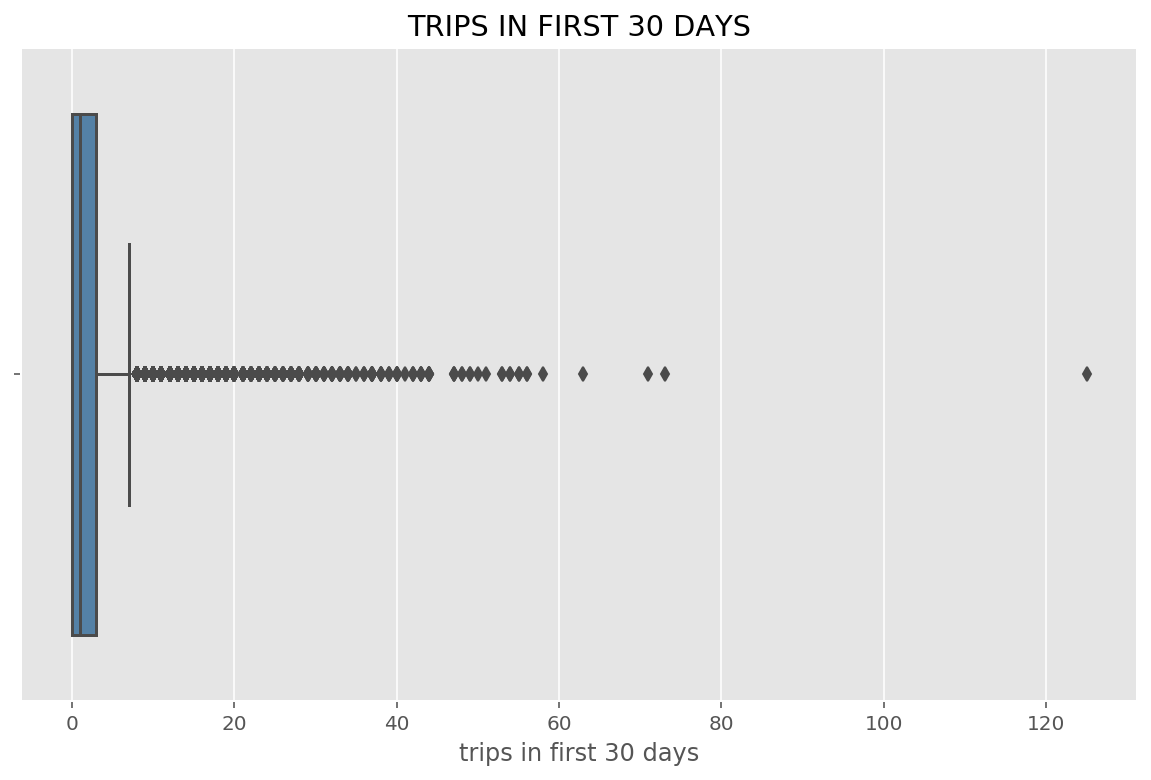

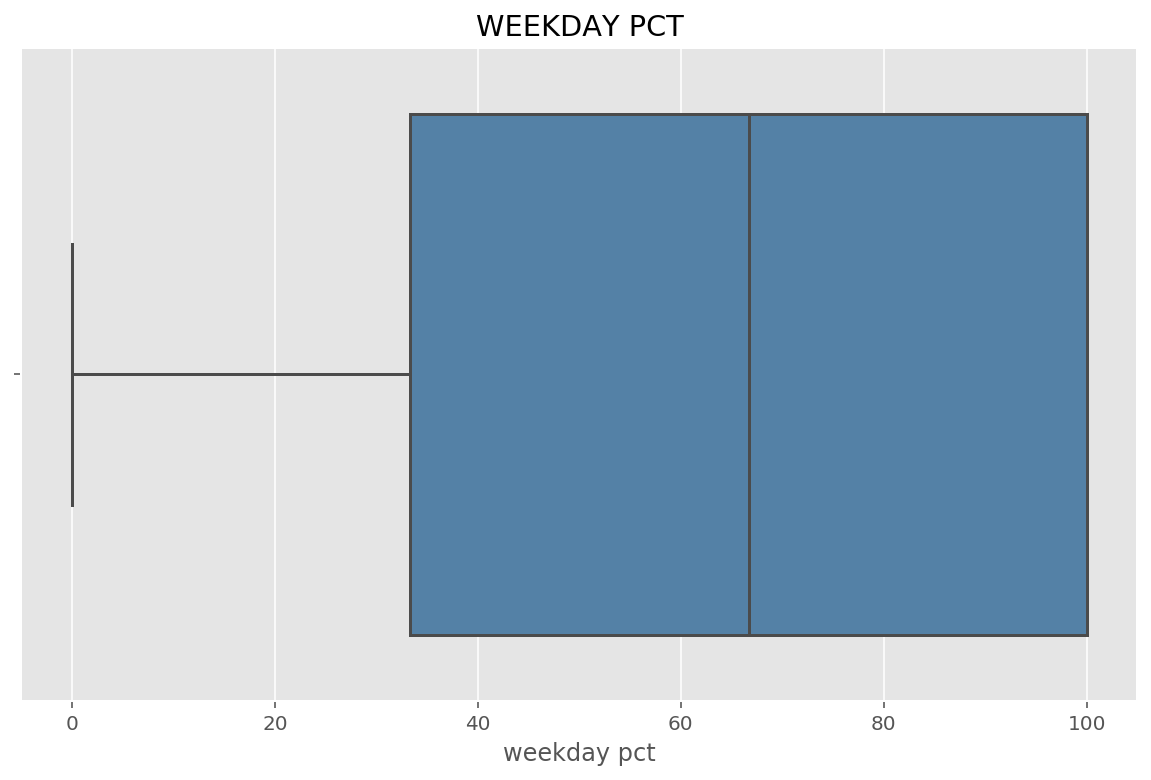

In [60]:
predict.boxplot(df, number_cols)

# _Observations_

We'll start by taking a look at the numeric columns and there is one thing very obvious from the boxplots above: outliers. The WWe need to address these before we go any further. 

There are a few methods that we can use to screen outliers, including (but not limited to):
- z-scores
- Grubb's test
- Tietjen-Moore test
- Inter-quartile 
- Tukey Method

Out of these, the last two - Inter-quartile and Tukey - are the most robust. Since both are based on the inter-quartile range (IQR) let's first define what exactly that is. The IQR is the difference between the 75th and 25th percentile of data. 

For the inter-quartile method outliers are either 1.5 IQRs below the first quartile or 1.5 IQRs above the thrid quartile in a given data set. The Tukey Method is an extension of this method but with the addition of 'fences', which essentially forms the cut-off for outliers. 

For our purposes we'll use the inter-quartile method, because it is relatively simple to implement via the `SciPy` library.

In [61]:
import scipy

In [66]:
q1, q3 = np.percentile(df['avg_dist'], [25, 75])
print(q1, q3)
print(q3 - q1)

2.42 6.94
4.5200000000000005


In [62]:
scipy.stats.iqr(df['avg_dist'])

4.5200000000000005

In [69]:
for col in df[['avg_dist', 'avg_surge']]:
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = scipy.stats.iqr(df[col])
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    print('Q1 for {} = {}, Q3 for {} = {}'.format(col, q1, col, q3))
    print('IQR for {} = {}'.format(col, iqr))
    print('Lower Bound for {} = {}'.format(col, lower_bound))
    print('Upper Bound for {} = {}'.format(col, upper_bound))
    print('-' * 40)

Q1 for avg_dist = 2.42, Q3 for avg_dist = 6.94
IQR for avg_dist = 4.5200000000000005
Lower Bound for avg_dist = -4.360000000000001
Upper Bound for avg_dist = 13.720000000000002
----------------------------------------
Q1 for avg_surge = 1.0, Q3 for avg_surge = 1.05
IQR for avg_surge = 0.050000000000000044
Lower Bound for avg_surge = 0.9249999999999999
Upper Bound for avg_surge = 1.125
----------------------------------------


# _IQR_

In [73]:
q1 = df[number_cols].quantile(0.25)
q3 = df[number_cols].quantile(0.75)
iqr = q3 - q1
print(iqr)

avg_dist                   4.52
avg_rating_by_driver       0.30
avg_rating_of_driver       0.50
avg_surge                  0.05
surge_pct                  8.60
trips_in_first_30_days     3.00
weekday_pct               66.70
dtype: float64


In [75]:
df_outlier = df[~((df[number_cols] < (q1 - 1.5 * iqr)) | (df[number_cols] > (q3 + 1.5 * iqr))).any(axis=1)]

In [77]:
df_outlier.shape

(29322, 12)

In [78]:
df.shape

(50000, 12)

# _Z-Score_

In [79]:
z = np.abs(scipy.stats.zscore(df[number_cols]))
print(z)

[[3.72650244e-01 4.97683632e-01 1.74240305e-01 ... 3.28202393e-01
  4.53983824e-01 3.97131451e-01]
 [4.31582983e-01 4.97683632e-01 7.05241067e-01 ... 4.43394376e-01
  6.00688784e-01 2.94653460e-01]
 [8.80771455e-01 4.97683632e-01 5.33760712e-01 ... 4.43394376e-01
  1.90315672e-01 1.05374117e+00]
 ...
 [3.39359544e-01 4.97683632e-01 7.05241067e-01 ... 4.43394376e-01
  6.00688784e-01 1.05374117e+00]
 [2.13205312e-01 2.86744158e+00 2.83476401e+00 ... 4.43394376e-01
  7.33524799e-02 1.05374117e+00]
 [4.04188802e-01 4.97683632e-01 2.76685738e-13 ... 4.43394376e-01
  6.00688784e-01 1.64304809e+00]]


In [80]:
threshold = 3
print(np.where(z > 3))

(array([    4,    14,    16, ..., 49983, 49991, 49992]), array([5, 0, 1, ..., 2, 4, 2]))


In [81]:
df_zscore = df[(z < 3).all(axis=1)]

In [82]:
df_zscore.shape

(44698, 12)

In [83]:
df.shape[0] - df_zscore.shape[0]

5302